In [1]:
import os, re
import pickle
import numpy as np
import pandas as pd

import joblib

#matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.cm as cm
from matplotlib.cm import ScalarMappable

import matplotlib.colors as mc
from mpl_toolkits.axes_grid1 import make_axes_locatable

#scipy
from scipy import ndimage
from scipy.stats import gaussian_kde

from sklearn import preprocessing
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV

In [25]:
path = '/home/wq_sat/notebooks/bathymetries/ML_SDB/data'
region = 'SanBou'
year = '2018'

train_df = pd.read_csv(os.path.join(path, '{}.csv'.format(region)))
train_df = train_df.dropna()

In [26]:
nearshore_df = train_df[train_df['Bathymetry'] > -5]
# nearshore_df = nearshore_df[['Bathymetry', 'B2', 'B3', 'B4', 'B5', 'chl',
#                              'Rt23', 'Rt24', 'Rt34', 'Lt4']]
nearshore_df

,Bathymetry,B2,B3,B4,B5,B8,chl,Rt23,Rt24,Rt28,Rt34,Rt38,Rt48,Lt2,Lt3,Lt4,Lt8
0,-1.874191,0.039589,0.042797,0.017714,0.010067,0.002112,2.244296,0.984104,1.200124,2.548970,1.219509,2.590143,2.123922,-3.733437,-3.691462,-4.147224,-7.123893
1,-1.752848,0.039589,0.042797,0.019400,0.010067,0.002112,2.372278,0.984104,1.173566,2.548970,1.192522,2.590143,2.171987,-3.733437,-3.691462,-4.045858,-7.123893
2,-1.260560,0.031925,0.036220,0.019400,0.010067,0.002075,2.372278,0.973338,1.121207,2.458216,1.151919,2.525552,2.192473,-4.119895,-3.997664,-4.045858,-7.170930
3,-1.788479,0.036579,0.038344,0.013741,0.006820,0.001568,2.220099,0.990167,1.260073,2.976223,1.272587,3.005778,2.361944,-3.867986,-3.888189,-4.436641,-8.251103
4,-1.633705,0.039589,0.042797,0.015979,0.007598,0.002238,2.220099,0.984104,1.231714,2.473654,1.251609,2.513610,2.008303,-3.733437,-3.691462,-4.263462,-6.979371
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29772,-4.480805,0.030434,0.025821,0.001967,0.001110,0.001497,1.648328,1.037400,2.504642,2.945699,2.414344,2.839500,1.176096,-3.714816,-3.809197,-6.817161,-7.569724
29773,-4.455250,0.030505,0.026392,0.001897,0.001091,0.001322,1.606886,1.032787,2.556768,3.204696,2.475601,3.102960,1.253417,-3.711914,-3.783748,-6.883168,-7.984478
29821,-4.707210,0.030434,0.025042,0.001967,0.001110,0.001520,1.606886,1.044681,2.504642,2.917837,2.397518,2.793041,1.164972,-3.714816,-3.844971,-6.817161,-7.527406
29822,-4.524520,0.030434,0.026078,0.002489,0.001094,0.002067,1.582686,1.035069,2.217794,2.437967,2.142654,2.355368,1.099276,-3.714816,-3.797671,-6.427209,-6.825762


In [27]:
far_df = train_df[train_df['Bathymetry'] <= -5]
# far_df = far_df[['Bathymetry', 'B2', 'B3', 'chl', 'Rt23', 'Lt3']]
far_df

,Bathymetry,B2,B3,B4,B5,B8,chl,Rt23,Rt24,Rt28,Rt34,Rt38,Rt48,Lt2,Lt3,Lt4,Lt8
567,-5.018471,0.031032,0.027456,0.002398,0.001917,0.002954,1.589794,1.027472,2.268050,2.055842,2.207409,2.000874,0.906436,-4.176438,-4.646550,-7.615458,-6.408589
666,-5.037329,0.028995,0.025181,0.002370,0.001374,0.001648,1.464863,1.032271,2.247530,2.744543,2.177267,2.658743,1.221138,-4.318781,-4.917183,-7.674117,-7.983163
877,-5.189074,0.029131,0.023240,0.002177,0.001607,0.001978,1.313648,1.052661,2.349642,2.472540,2.232097,2.348847,1.052305,-4.308591,-5.225222,-8.213251,-7.305927
912,-5.112021,0.029208,0.023014,0.002157,0.001607,0.002420,1.593091,1.055685,2.362395,2.228161,2.237783,2.110631,0.943179,-4.302886,-5.268220,-8.290144,-6.800517
946,-5.027897,0.028378,0.023607,0.002290,0.001596,0.002336,1.221651,1.042751,2.275900,2.252998,2.182593,2.160630,0.989937,-4.366242,-5.159340,-7.863894,-6.878595
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30388,-13.587421,0.019546,0.010339,0.001789,0.001536,0.001824,0.557448,1.182991,2.385670,2.359056,2.016642,1.994145,0.988844,-4.307193,-5.008013,-6.994505,-7.079372
30389,-13.872078,0.017905,0.009744,0.001721,0.001531,0.001667,0.700254,1.177863,2.388639,2.434333,2.027944,2.066737,1.019130,-4.437018,-5.101218,-7.071722,-7.285543
30390,-13.645105,0.013478,0.007538,0.001356,0.001291,0.001551,0.561064,1.183659,2.585492,2.366140,2.184321,1.999004,0.915160,-4.905757,-5.551115,-7.633501,-7.471544
30391,-12.646940,0.007860,0.004730,0.001091,0.000981,0.001108,0.432640,1.188294,2.604683,2.570642,2.191952,2.163305,0.986931,-6.327678,-6.835654,-8.427622,-8.972170


In [28]:
nearshore_df.join(far_df)

ValueError: columns overlap but no suffix specified: Index(['Bathymetry', 'B2', 'B3', 'B4', 'B5', 'B8', 'chl', 'Rt23', 'Rt24',
       'Rt28', 'Rt34', 'Rt38', 'Rt48', 'Lt2', 'Lt3', 'Lt4', 'Lt8'],
      dtype='object')

## Nearshore model

In [5]:
nearshore_df = train_df[train_df['Bathymetry'] > -5]
nearshore_df = nearshore_df[['Bathymetry', 'B2', 'B3', 'B4', 'B5', 'chl',
                             'Rt23', 'Rt24', 'Rt34', 'Lt4']]
nearshore_df = nearshore_df.to_numpy()
nearshore_df.shape

(12653, 10)

In [6]:
scaler = preprocessing.StandardScaler()
x_train = scaler.fit_transform(nearshore_df[:,1:])
print('x_train shape: {}'.format(x_train.shape))

y_train = nearshore_df[:,0]
print('y_train shape: {}'.format(y_train.shape))

x_train shape: (12653, 9)
y_train shape: (12653,)


In [9]:
param_grid = {
    'n_estimators': [50, 150, 250],
    'max_depth': [40, 80, 120],
    'min_samples_split': [4, 8, 12],
    'min_samples_leaf': [1, 2, 4],
    'learning_rate': [0.01, 0.05, 0.1]
}

gbr = GradientBoostingRegressor()
grid_search = GridSearchCV(estimator = gbr, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)
grid_search.fit(x_train, y_train)

Fitting 3 folds for each of 243 candidates, totalling 729 fits


GridSearchCV(cv=3, estimator=GradientBoostingRegressor(), n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.05, 0.1],
                         'max_depth': [40, 80, 120],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [4, 8, 12],
                         'n_estimators': [50, 150, 250]},
             verbose=2)

In [10]:
print(" Results from Random Search " )
print("\n The best estimator across ALL searched params:\n", grid_search.best_estimator_)
print("\n The best score across ALL searched params:\n", grid_search.best_score_)
print("\n The best parameters across ALL searched params:\n", grid_search.best_params_)

 Results from Random Search 

 The best estimator across ALL searched params:
 GradientBoostingRegressor(learning_rate=0.01, max_depth=40, min_samples_leaf=4,
                          min_samples_split=12, n_estimators=150)

 The best score across ALL searched params:
 0.6390960320807951

 The best parameters across ALL searched params:
 {'learning_rate': 0.01, 'max_depth': 40, 'min_samples_leaf': 4, 'min_samples_split': 12, 'n_estimators': 150}


In [ ]:
#{'max_depth': 90, 'max_features': 2, 'min_samples_leaf': 5, 'min_samples_split': 10, 'n_estimators': 300}
#(learning_rate=0.05, max_depth=10, min_samples_split=5, n_estimators=50)

In [7]:
# Fit regression model
best_params = {'learning_rate': 0.01, 
               'max_depth': 40, 
               'min_samples_leaf': 4, 
               'min_samples_split': 12, 
               'n_estimators': 150}

gbregr = GradientBoostingRegressor(**best_params)
gbregr.fit(x_train, y_train)

GradientBoostingRegressor(learning_rate=0.01, max_depth=40, min_samples_leaf=4,
                          min_samples_split=12, n_estimators=150)

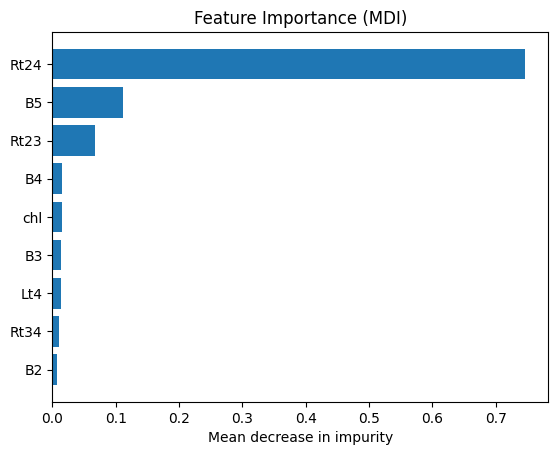

In [8]:
feature_names = ['B2', 'B3', 'B4', 'B5', 'chl', 'Rt23', 'Rt24', 'Rt34', 'Lt4']

# obtain feature importance
feature_importance = gbregr.feature_importances_

# sort features according to importance
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0])

# plot feature importances
plt.barh(pos, feature_importance[sorted_idx], align="center")

plt.yticks(pos, np.array(feature_names)[sorted_idx])
plt.title("Feature Importance (MDI)")
plt.xlabel("Mean decrease in impurity");

## Test

In [10]:
path = '/home/wq_sat/notebooks/bathymetries/ML_SDB/data'
region = 'CalaMillor'
year = '2020'

test_df = pd.read_csv(os.path.join(path, '{}_{}.csv'.format(region, year)))
test_df = test_df.dropna()

In [11]:
nearshore_df = test_df[test_df['Bathymetry'] > -5]
nearshore_df = nearshore_df[['Bathymetry', 'B2', 'B3', 'B4', 'B5', 'chl',
                             'Rt23', 'Rt24', 'Rt34', 'Lt4']]
nearshore_df = nearshore_df.to_numpy()
nearshore_df.shape

(3299, 10)

In [12]:
scaler = preprocessing.StandardScaler()
x_test = scaler.fit_transform(nearshore_df[:,1:])
print('x_test shape: {}'.format(x_test.shape))

y_test = nearshore_df[:,0]
print('y_test shape: {}'.format(y_test.shape))

x_test shape: (3299, 9)
y_test shape: (3299,)


In [13]:
# Predict
y_predict = gbregr.predict(x_test)

# test
y_test = y_test.reshape(-1)

/tmp/ipykernel_151396/194756714.py:20: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  axs[0].plot([0,15], [0,15], 'k-', c='r', alpha=0.75, zorder=0)


Text(0.5, 1.0, 'Error')

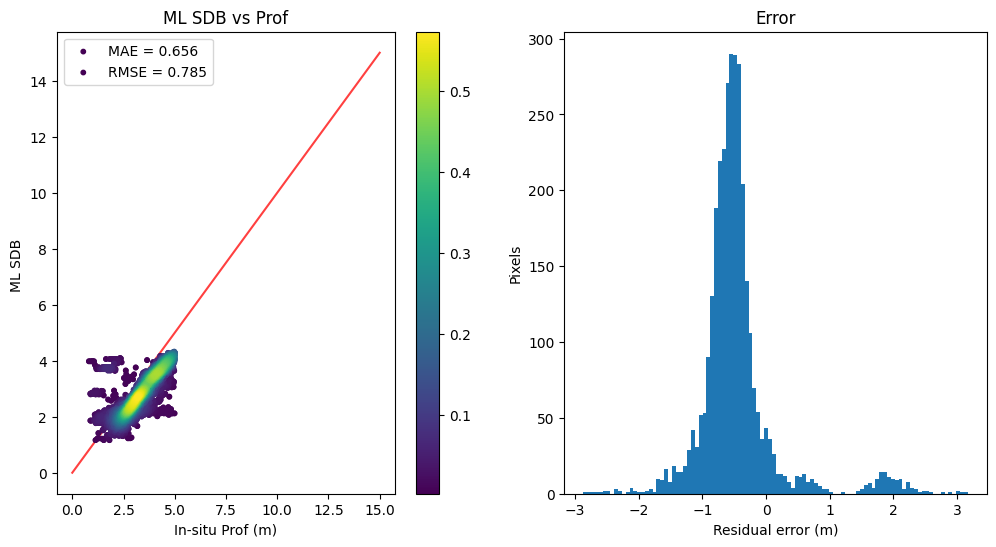

In [14]:
diff = y_test - y_predict

# Calculate the point density
x = - y_test
y = - y_predict
xy = np.vstack([x, y])
z = gaussian_kde(xy)(xy)

# Sort the points by density, so that the densest points are plotted last
idx = z.argsort()
x, y, z = x[idx], y[idx], z[idx]

MAE = np.nanmean(np.abs(diff))
RMSE = np.sqrt(np.nanmean(diff**2))

fig, axs = plt.subplots(1, 2, figsize=(12, 6))
axs[0].scatter(x, y, c=z, s=10, label=f'MAE = {MAE:.3f}')
ax_ = axs[0].scatter(x, y, c=z, s=10, label=f'RMSE = {RMSE:.3f}')
plt.colorbar(ax_)
axs[0].plot([0,15], [0,15], 'k-', c='r', alpha=0.75, zorder=0)
axs[0].set_xlabel("In-situ Prof (m)")
# axs[0].set_xlim(0,15)
axs[0].set_ylabel("ML SDB ")
# axs[0].set_ylim(0,15)
axs[0].legend()
axs[0].set_title("ML SDB vs Prof")

axs[1].hist(diff.flatten(), bins=100)
# axs[1].set_xlim(-4,4)
axs[1].set_xlabel("Residual error (m)")
axs[1].set_ylabel("Pixels")
axs[1].set_title("Error")